<a href="https://colab.research.google.com/github/FarhinaMirza/CE888/blob/main/causal_Inference_a2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**CATE estimator from EconML package**

In [ ]:
!pip install econml

     |████████████████████████████████| 3.3 MB 7.8 MB/s 
     |████████████████████████████████| 77 kB 4.1 MB/s 
     |████████████████████████████████| 123 kB 42.9 MB/s 
     |████████████████████████████████| 356 kB 41.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491658 sha256=01d84ae60386f6bee90cf3bdc8f475213e3113517ff22e5e1396dbbbaef69fd2
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


###**Import Libraries from EconML, together with the rest of the packages we need**

In [ ]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn

###**implement the two Metrics for ATE and PEHE**

In [ ]:
def abs_ate(effect_true, effect_pred):

    return np.abs(np.mean(effect_pred) - np.mean(effect_true))

def pehe(effect_true, effect_pred):
   
    return np.sqrt(np.mean((effect_true - effect_pred) ** 2))

###**Uploading Data**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving jobs.csv to jobs.csv


In [ ]:
df1 = pd.read_csv('ihdp.csv')

In [ ]:
df1.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x20,x21,x22,x23,x24,x25,t,yf,ycf,ite
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.771232,-0.298509,4.657928
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.956273,5.783770,3.428604
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.164164,7.055789,3.658195
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.172307,1.379697,4.585505
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.834469,2.747986,4.265591


###**correlation matrix for IHDP**

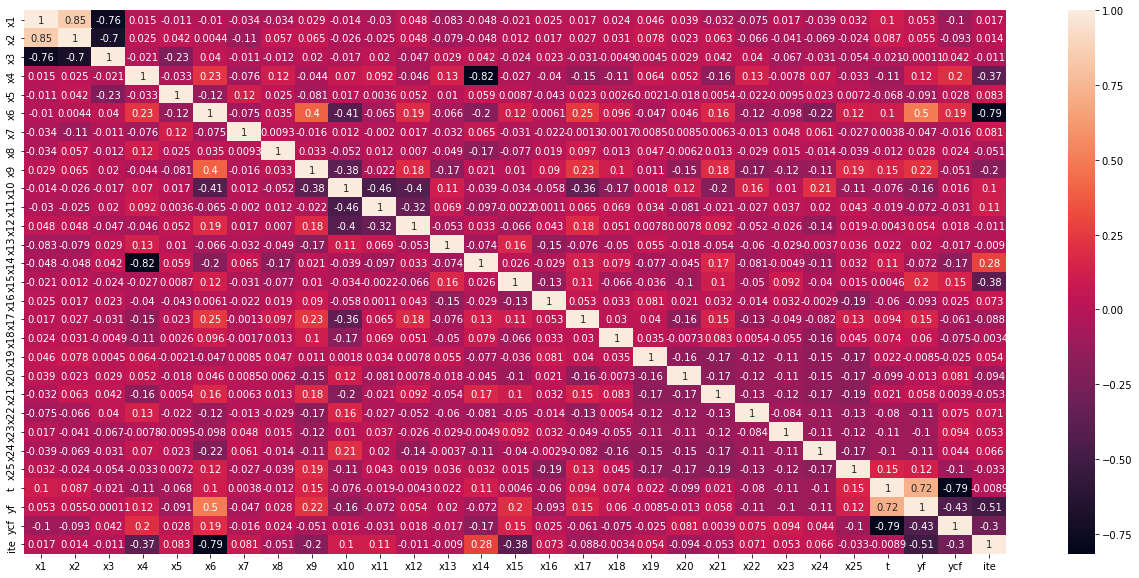

In [ ]:
plt.figure(figsize=(22,10))
f = sns.heatmap(df1.corr(),annot = True)

In [ ]:
X   = df1
T   = df1['t'].reshape(-1,2)
YF  = df1['yf'].reshape(-1,2)
YCF = df1['ycf'].rehsape(-1,2)
ITE = df1['ite']

###**Exploratory data analysis of IHDP data**

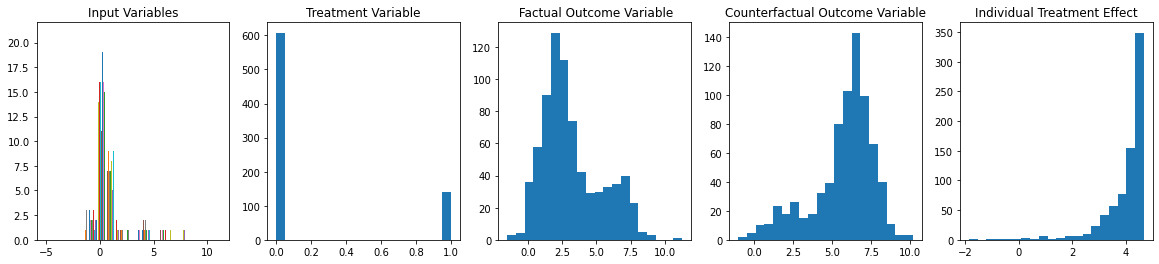

In [ ]:
bins=20
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
ax[0].set_title('Input Variables')
ax[1].set_title('Treatment Variable')
ax[2].set_title(' Factual Outcome Variable')
ax[3].set_title('Counterfactual Outcome Variable')
ax[4].set_title('Individual Treatment Effect')
ax[0].hist(X, bins=bins)
ax[1].hist(T, bins=bins)
ax[2].hist(YF, bins=bins)
ax[3].hist(YCF, bins=bins)
ax[4].hist(ITE, bins=bins)
#plt.title('Exploratory Data Analysis of IHDP Data')
plt.show()

X, YF and YCF clearly follow the shape of the normal distribution, as expected. Tretment is binary, i.e., consists of 0 and 1 values. All ITE values are slightly higher than 4.0, which is correct as we know the ATE is 4.01606689611834

In [ ]:
ITE.mean()

###**scatter plots for IHDP**

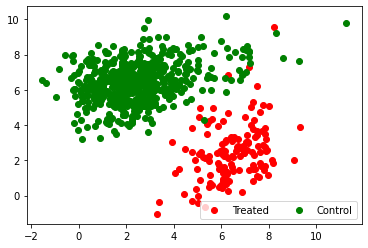

In [ ]:
limit = 1000
plt.scatter(YF[T == 1][:limit], YCF[T == 1][:limit], c = "r", label = "Treated")
plt.scatter(YF[T == 0][:limit], YCF[T == 0][:limit], c = "g", label = "Control")
plt.legend(ncol=2)

The effect is easy to notice as it is clearly seen in plot, in some regions the treated units (red) are a lesser than the control ones (green), which demonstrates the effect (treated units have lesser outcomes).

###**Splitting the Dataset into training and test set**

In [34]:
#Split the data into training and testing for evaluation purposes with 80/20 ratio.

x_train, x_test, t_train, t_test, yf_train, yf_test, ycf_train, ycf_test, ite_train, ite_test = train_test_split(X, T, YF, YCF, ITE, test_size=0.2)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

###**Training the IHDP dataset**
I am going to use three estimators here:

*   Random Forest Regressor

*   Random Forest with Inverse Propensity Weighting (IPW).
*   X-learner with RF as base learners.





###**Random Forest Regressor**

In [ ]:
rf_cls = RandomForestRegressor()
# Train on the training data

rf_cls.fit(t_train, yf_train)